# VAE for Anomaly Detection

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Step 1: Define the VAE Model

In [2]:


class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x.view(-1, 784)))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Step 2: Define the Loss Function (ELBO)

In [3]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_div


Step 3: Load MNIST Dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Step 4: Train the Model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100

train_losses = []
KL_divergence = []
reconstruction_loss = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    kl_div = 0
    recon_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        kl_div += torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).item()
        recon_loss += nn.functional.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum').item()

    train_losses.append(train_loss / len(train_loader.dataset))
    KL_divergence.append(kl_div / len(train_loader.dataset))
    reconstruction_loss.append(recon_loss / len(train_loader.dataset))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'KL Div: {kl_div/len(train_loader.dataset):.4f}, Recon Loss: {recon_loss/len(train_loader.dataset):.4f}')


Epoch [1/100], Loss: 163.7775, KL Div: 15.6081, Recon Loss: 148.1694
Epoch [2/100], Loss: 120.8178, KL Div: 22.3734, Recon Loss: 98.4444
Epoch [3/100], Loss: 114.1057, KL Div: 23.9442, Recon Loss: 90.1615
Epoch [4/100], Loss: 111.3310, KL Div: 24.5098, Recon Loss: 86.8213
Epoch [5/100], Loss: 109.6222, KL Div: 24.7263, Recon Loss: 84.8959
Epoch [6/100], Loss: 108.4844, KL Div: 24.8720, Recon Loss: 83.6124
Epoch [7/100], Loss: 107.6852, KL Div: 24.9985, Recon Loss: 82.6868
Epoch [8/100], Loss: 107.0143, KL Div: 25.0323, Recon Loss: 81.9820
Epoch [9/100], Loss: 106.4752, KL Div: 25.1218, Recon Loss: 81.3534
Epoch [10/100], Loss: 106.0939, KL Div: 25.1683, Recon Loss: 80.9257
Epoch [11/100], Loss: 105.7739, KL Div: 25.2351, Recon Loss: 80.5388
Epoch [12/100], Loss: 105.4478, KL Div: 25.2711, Recon Loss: 80.1767
Epoch [13/100], Loss: 105.1900, KL Div: 25.2958, Recon Loss: 79.8941
Epoch [14/100], Loss: 104.9577, KL Div: 25.3355, Recon Loss: 79.6221
Epoch [15/100], Loss: 104.7821, KL Div: 25

In [10]:
# Generate anomalous data by adding noise
def add_noise(img, noise_factor=0.5):
    noisy_img = img + noise_factor * torch.randn(*img.shape, device = img.device)
    return torch.clip(noisy_img, 0., 1.)


For anomaly detection, the reconstruction error for each individual image is calculated using MSE between the input and reconstructed image, normalized and averaged per pixel (or per sample).

In [11]:
# Evaluate the model on normal and noisy (anomalous) test data
model.eval()
normal_errors = []
anomalous_errors = []


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(next(model.parameters()).device)
        recon, _, _ = model(data)
        errors = ((recon - data.view(-1, 28*28)) ** 2).mean(dim=1)
        normal_errors.extend(errors.cpu().numpy())
        
        # Create and evaluate on noisy (anomalous) data
        noisy_data = add_noise(data)
        recon_noisy, _, _ = model(noisy_data)
        errors_noisy = ((recon_noisy - noisy_data.view(-1, 28*28)) ** 2).mean(dim=1)
        anomalous_errors.extend(errors_noisy.cpu().numpy())

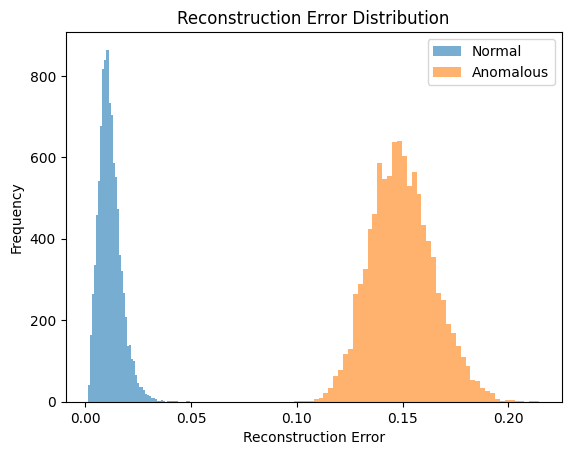

In [12]:
# Plot reconstruction error distribution
plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(anomalous_errors, bins=50, alpha=0.6, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Reconstruction Error Distribution')
plt.show()

Here, from above figure, choosing a threshold of 0.08 can correctly distinguish clean vs. noisy image. It can be shown as below:

In [15]:
import numpy as np

# Set threshold for anomaly detection based on visual inspection
threshold = 0.08
print(f"Threshold for anomaly detection: {threshold}")

# Classify images based on the threshold
normal_pred = np.array(normal_errors) > threshold  # True if above threshold (anomalous), False if below (normal)
anomalous_pred = np.array(anomalous_errors) > threshold

# Calculate classification accuracy
normal_accuracy = 1 - normal_pred.mean()  # Fraction of normal data correctly classified as normal
anomalous_accuracy = anomalous_pred.mean()  # Fraction of anomalous data correctly classified as anomalous

print(f"Normal classification accuracy: {normal_accuracy:.2f}")
print(f"Anomalous classification accuracy: {anomalous_accuracy:.2f}")


Threshold for anomaly detection: 0.08
Normal classification accuracy: 1.00
Anomalous classification accuracy: 1.00


In [25]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 108.6 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 255.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 116.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.2.15 requires pandas>=1.1.4, which is not installed.
ultralytics 8.2.15 requires seaborn>=0.11.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [26]:

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [28]:


# Extract latent vectors from test data
latent_vectors = []
labels = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(next(model.parameters()).device)
        _, mu, _ = model.encode(data)
        latent_vectors.append(mu.cpu().numpy())
        labels.extend(target.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.array(labels)

# Perform dimensionality reduction (choose either PCA or t-SNE)
# Using PCA to reduce to 2D
latent_2d = PCA(n_components=2).fit_transform(latent_vectors)

# Optionally, using t-SNE for better visualization (uncomment if preferred)
# latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)

# Plot the latent space with colors based on digit labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Digit Class')
plt.title("2D Visualization of VAE Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

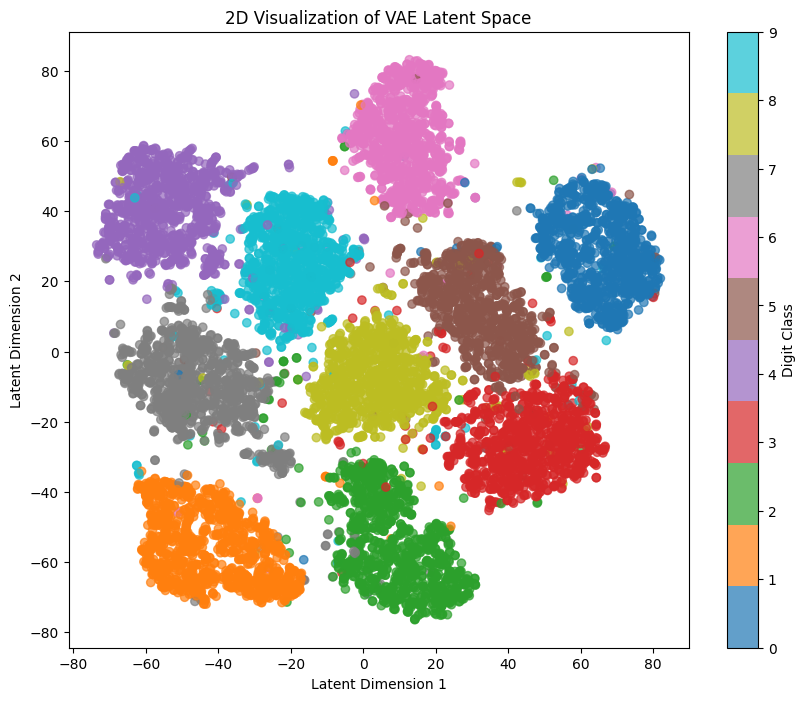

In [30]:
# Extract latent vectors from test data
latent_vectors = []
labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(next(model.parameters()).device)  # Move data to the same device as model
        mu, _ = model.encode(data)  # Only use the mean from the encoder output
        latent_vectors.append(mu.cpu().numpy())  # Convert to numpy and store
        labels.extend(target.numpy())  # Append the labels (targets)

# Concatenate the list of latent vectors and convert labels to numpy array
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.array(labels)

# Perform dimensionality reduction using PCA (or t-SNE if you prefer)
latent_2d = PCA(n_components=2).fit_transform(latent_vectors)

# Optionally, use t-SNE (uncomment the following line if you want to use t-SNE instead of PCA)
latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)

# Plot the latent space with colors based on digit labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Digit Class')
plt.title("2D Visualization of VAE Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()